In [1]:
!pip install gdown

# Download the whole folder using its ID
!gdown --folder --id 1wi3bgxTaNLY1AJMXdFxHHCrb1d4DGq9z -O ./dataset

# Check what files got downloaded
import os
os.listdir("./dataset")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Retrieving folder 1vJph3CisJx68_jHVFH_eRHdwBFqbQ7Zo Advanced
Processing file 1SmrrM5PwhIxtFMqWf4qppUSqaZNPj6sT all_data.csv
Processing file 1aEqB2NMLxPmdSV6tNLclnDdTLUKPMpdx identity_individual_annotations.csv
Processing file 1uxfIZB2xWyl0uQrtl9gu6vTwDp4LLO0V sample_submission.csv
Processing file 1VyiuWrhxa0S3etkylqJd7dFJ_sHPAyLJ test_private_expanded.csv
Processing file 1_JTTOT_nVcuBTJ81OlmcfePiSx9rEuxK test_public_expanded.csv
Processing file 1YeUL1ogLTp9cnoLCBTMM0-BPaExdOelU test.csv
Processing file 1Q_vG-6SDfJ-X6d1QBvewPR3EEEPpvsOu toxicity_individual_annotations.csv
Processing file 1X0kMv7VhdnrIvxiE6UX0DKkQRH75Jt2G train.csv
Retrieving folder 1SkkYoS9yCUjZh1ke6Vkc5mh9i9KfjnaS Basic
Processing file 1m05LhKQ_1OLhVcwEvxnylAC8hpZccn4l Copy o

['Advanced', 'Basic']

In [2]:
import os

os.listdir("./dataset/Advanced") # here you will see all the files that are in the Advanced folder

['test.csv',
 'all_data.csv',
 'identity_individual_annotations.csv',
 'sample_submission.csv',
 'test_private_expanded.csv',
 'test_public_expanded.csv',
 'train.csv',
 'toxicity_individual_annotations.csv']

In [3]:
# let's upload all the libraries that we need here:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('wordnet')
nltk.download("omw-1.4")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
train_df = pd.read_csv("./dataset/Advanced/train.csv")
test_df = pd.read_csv("./dataset/Advanced/test.csv")
test_labels_df = pd.read_csv("./dataset/Advanced/sample_submission.csv")

In [5]:
test_df

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...
...,...,...
97315,7194635,He should lose his job for promoting mis-infor...
97316,7194636,"""Thinning project is meant to lower fire dange..."
97317,7194637,I hope you millennials are happy that you put ...
97318,7194638,I'm thinking Kellyanne Conway (a.k.a. The Trum...


In [6]:
test_labels_df

,id,prediction
0,7097320,0.0
1,7097321,0.0
2,7097322,0.0
3,7097323,0.0
4,7097324,0.0
...,...,...
97315,7194635,0.0
97316,7194636,0.0
97317,7194637,0.0
97318,7194638,0.0


In [7]:
merged_df = test_df.merge(test_labels_df, on="id", how="left")

In [8]:
print("All test IDs in sample_submission?",
      set(test_df['id']).issubset(set(test_labels_df['id'])))

All test IDs in sample_submission? True


In [9]:
print("are they the same shape?",test_labels_df.shape == test_df.shape)
# if they are the same shape that means it's really the answer fpr the test set, which will be used later for evaluation

are they the same shape? True


# EDA & Handling messing values

In [10]:
train_df.shape

(1804874, 45)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [12]:
train_df.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


- The **`"target"`** column is a continuous values between 0 & 1

In [13]:
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [14]:
train_df.isnull().sum()

,0
id,0
target,0
comment_text,3
severe_toxicity,0
obscene,0
identity_attack,0
insult,0
threat,0
asian,1399744
atheist,1399744



- we will drop the missing ones in the `'comment_text'` column since they are not that much
- for the `'identity_columns'` we will use the fill NaN values with 0 (indicating no mention of that identity) and the same goes with parent_id 0 = this is not a reply

In [15]:
identity_columns = [
    'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white'
]

train_df[identity_columns] = train_df[identity_columns].fillna(0)

In [16]:
train_df = train_df.dropna(subset=['comment_text'])

In [17]:
train_df = train_df.dropna(subset=['created_date'])

In [18]:
train_df['parent_id'] = train_df['parent_id'].fillna(0)

In [19]:
# let's check again:
train_df.isnull().sum()

,0
id,0
target,0
comment_text,0
severe_toxicity,0
obscene,0
identity_attack,0
insult,0
threat,0
asian,0
atheist,0


# Data Visualization

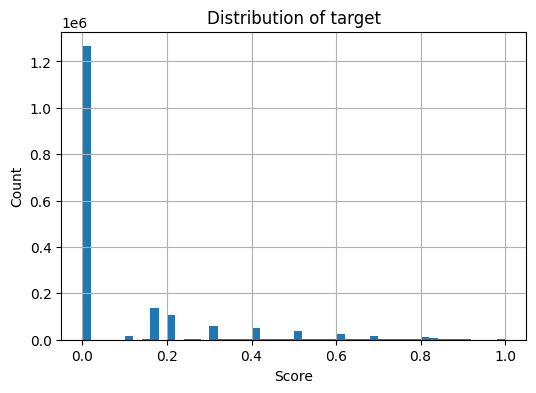

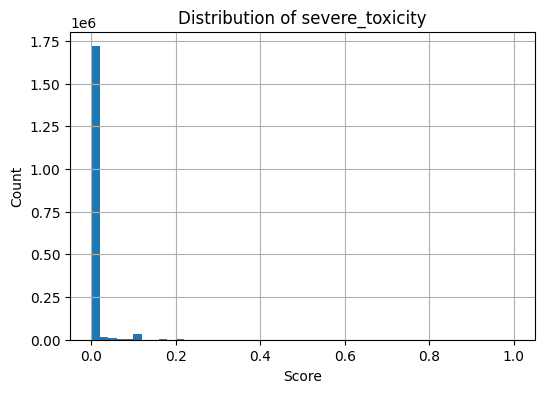

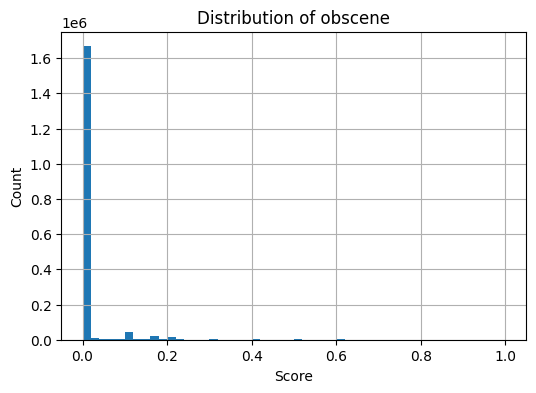

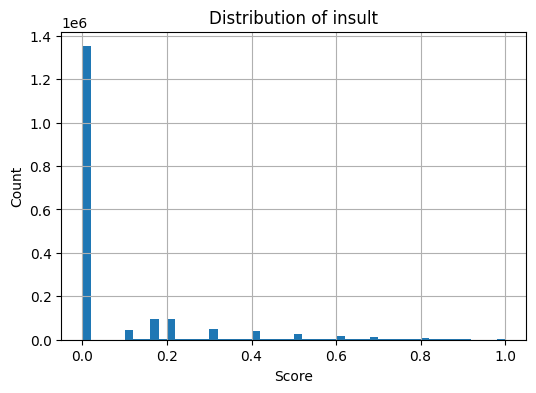

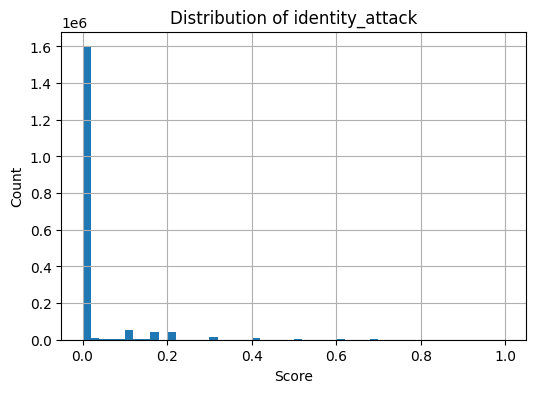

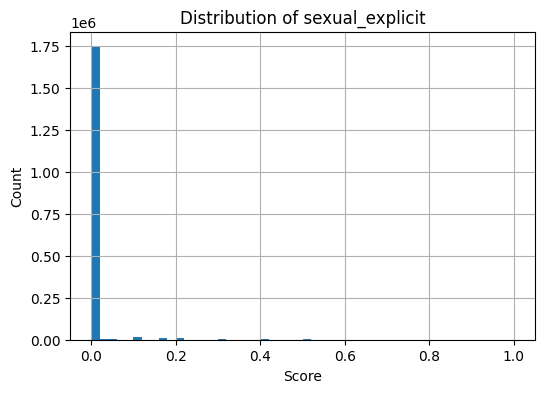

In [20]:
import matplotlib.pyplot as plt

targets = ['target','severe_toxicity','obscene','insult','identity_attack','sexual_explicit']

for col in targets:
    plt.figure(figsize=(6,4))
    train_df[col].hist(bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.show()

- Insight: Most values are near zero, meaning most comments are not toxic

In [21]:
train_df['created_date'] # let's visualize it to get to know more about toxic content

,created_date
0,2015-09-29 10:50:41.987077+00
1,2015-09-29 10:50:42.870083+00
2,2015-09-29 10:50:45.222647+00
3,2015-09-29 10:50:47.601894+00
4,2015-09-29 10:50:48.488476+00
...,...
1804869,2017-11-11 00:55:39.265997+00
1804870,2017-11-11 00:55:56.634498+00
1804871,2017-11-11 00:59:02.840713+00
1804872,2017-11-11 01:01:10.153692+00


In [22]:
train_df["created_date"] = pd.to_datetime(
    train_df["created_date"],
    format="%Y-%m-%d %H:%M:%S.%f%z",
    errors="coerce" # Convert problematic dates to NaT instead of crashing
)

# Choose identity groups to plot
identity_groups = {
    "Race": ["white", "asian", "black", "jewish", "latino", "other_race_or_ethnicity"],
    "Religion": ["atheist", "buddhist", "christian", "hindu", "muslim", "other_religion", "jewish"],
    "Sexual Orientation": ["heterosexual", "homosexual_gay_or_lesbian", "bisexual", "other_sexual_orientation"],
    "Gender": ["male", "female", "transgender", "other_gender"]
}

In [23]:
df_sample_for_visualization = train_df.sample(frac=0.2, random_state=42)

In [24]:
# Resample to monthly and compute mean toxicity for each group
def group_time_series(df, group_cols):
    out = {}
    for col in group_cols:
        subset = df[df[col] > 0.5]  # >0.5 means identity is mentioned
        ts = (train_df[train_df[col] > 0]
              .resample("M", on="created_date")["target"] # # Group by month
              .mean() # Average toxicity per month
              .rolling(window=3, min_periods=1) # # 3-month moving average
              .mean()) # smooth it out

        out[col] = ts
    return pd.DataFrame(out)

/tmp/ipython-input-2255356819.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M", on="created_date")["target"] # # Group by month
/tmp/ipython-input-2255356819.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M", on="created_date")["target"] # # Group by month
/tmp/ipython-input-2255356819.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M", on="created_date")["target"] # # Group by month
/tmp/ipython-input-2255356819.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M", on="created_date")["target"] # # Group by month


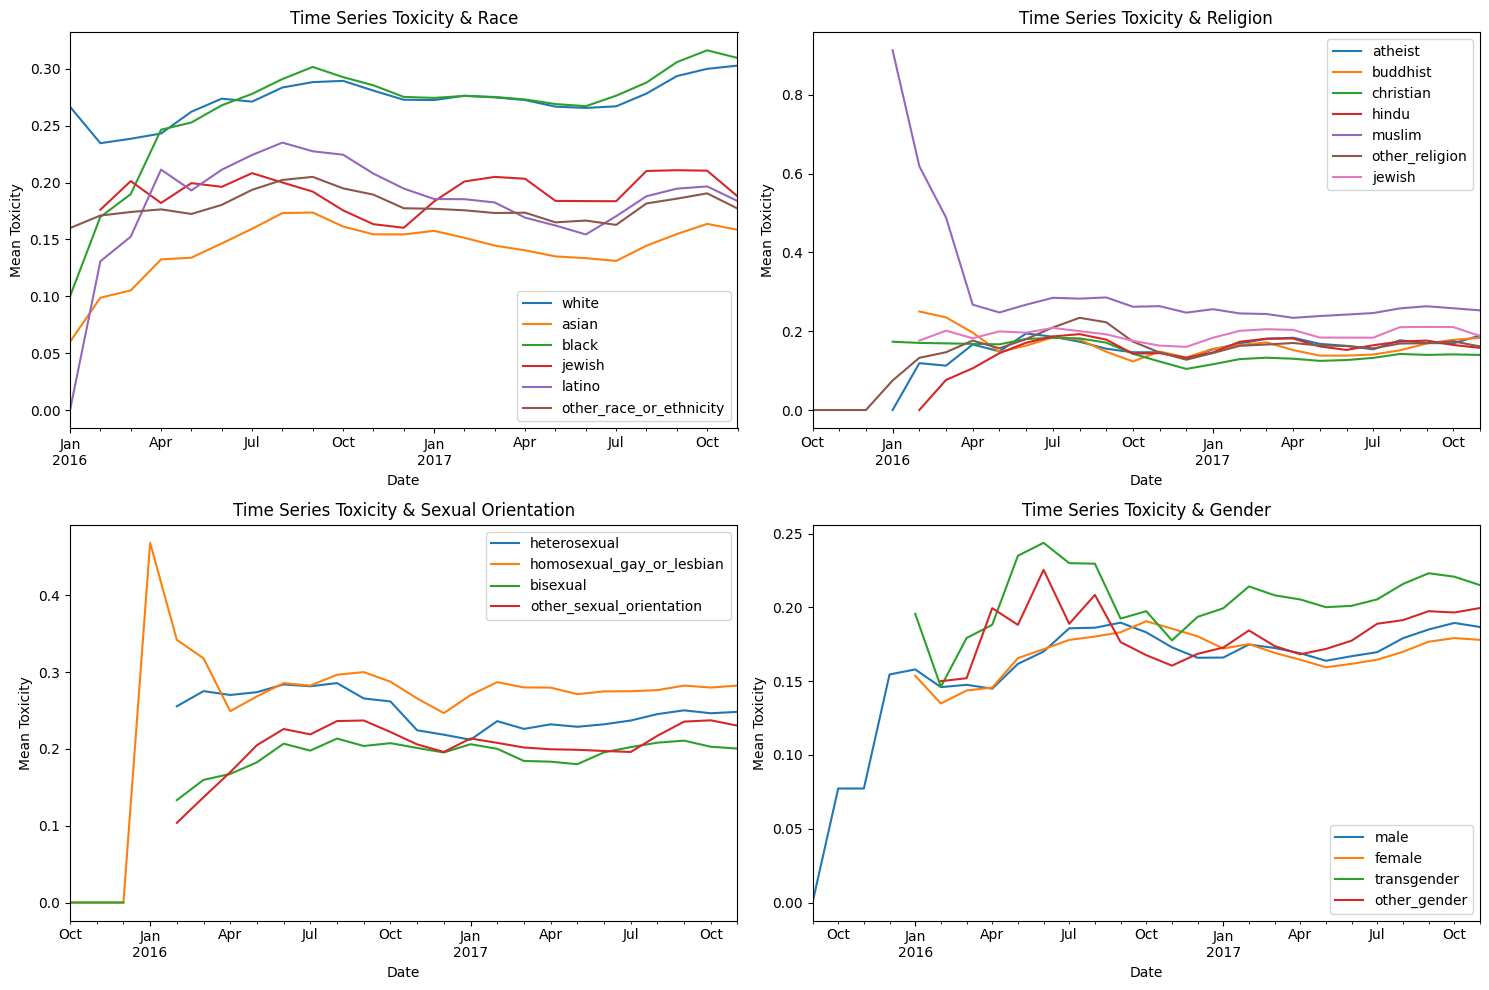

In [25]:
# Plot,  2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (title, cols) in enumerate(identity_groups.items()):
    ts_df = group_time_series(df_sample_for_visualization, cols)
    ts_df.plot(ax=axes[i])
    axes[i].set_title(f"Time Series Toxicity & {title}")
    axes[i].set_ylabel("Mean Toxicity")
    axes[i].set_xlabel("Date")

#  Apply automatic spacing adjustment, bc words overlap if not used
plt.tight_layout()
plt.show()

Insights:
- Toxicity against "muslim" group spiked in specific months
- "black" identity consistently receives high toxicity  

---


In [26]:
df_sample_for_visualization['word_count'] = df_sample_for_visualization['comment_text'].str.split().str.len()

In [27]:
# let's define a temp threshold to determine whether or not there's a class imbalance:
df_sample_for_visualization['is_toxic'] = (df_sample_for_visualization['target'] >= 0.5).astype(int)

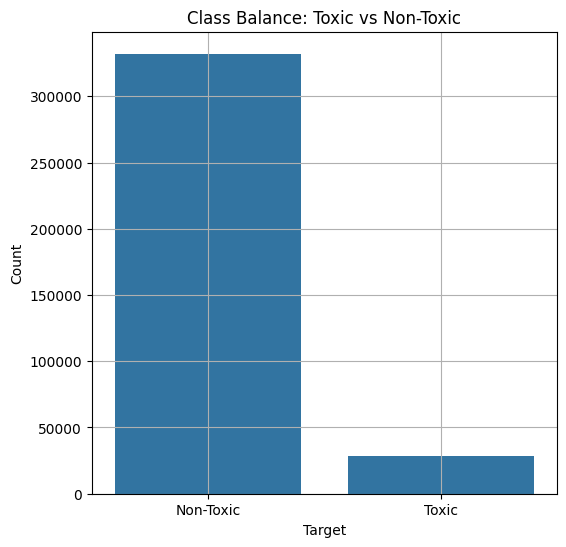

In [28]:
# now let's visualize it
plt.figure(figsize=(6,6))
sns.countplot(x='is_toxic', data=df_sample_for_visualization)
plt.xticks([0,1], ['Non-Toxic','Toxic'])
plt.title("Class Balance: Toxic vs Non-Toxic")
plt.xlabel("Target")
plt.ylabel("Count")
plt.grid(True)
plt.show()

- Insight: there might be a class-imbalance

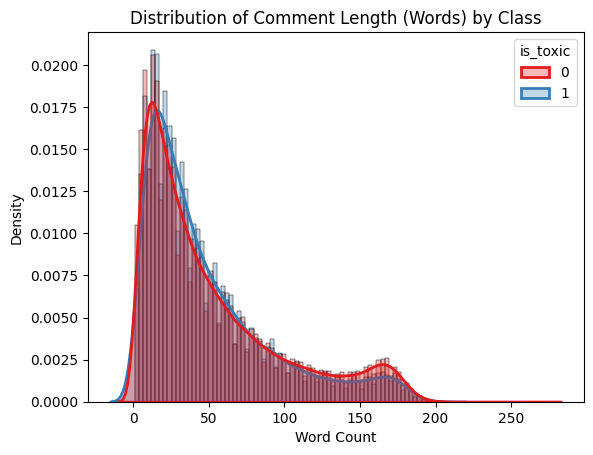

In [29]:
# Base hist with transparency
sns.histplot(
    data=df_sample_for_visualization,
    x='word_count',
    hue='is_toxic',
    bins=100,
    palette="Set1",
    stat="density",
    common_norm=False,
    alpha=0.3
)

# Overlay stronger KDE curves with shading
sns.kdeplot(
    data=df_sample_for_visualization,
    x='word_count',
    hue='is_toxic',
    palette="Set1",
    common_norm=False,
    fill=True,        # fills under the KDE
    alpha=0.3,        # how shadowed the area looks
    linewidth=2       # makes the KDE lines bold
)

plt.title("Distribution of Comment Length (Words) by Class")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.show()

insight => comment length both toxic and non-toxic looks almost same only

In [30]:
# Word cloud for toxic comments
toxic_text = " ".join(df_sample_for_visualization[df_sample_for_visualization['is_toxic']==1]['comment_text'].astype(str).tolist())
non_toxic_text = " ".join(df_sample_for_visualization[df_sample_for_visualization['is_toxic']==0]['comment_text'].astype(str).tolist())

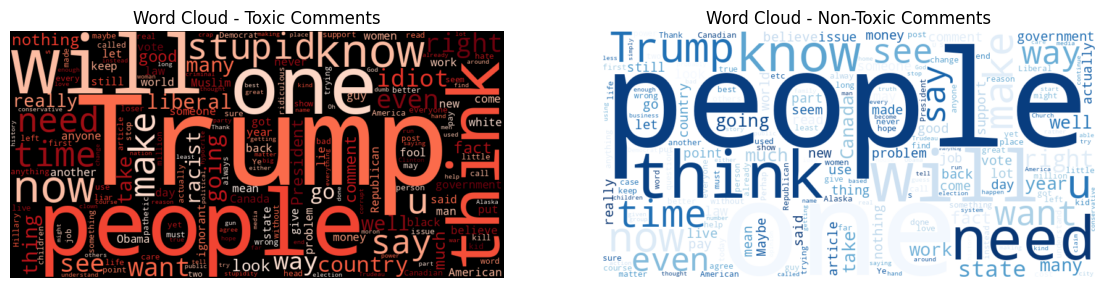

In [31]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
wc_toxic = WordCloud(width=800, height=400, max_words=200, background_color="black", colormap="Reds").generate(toxic_text)
plt.imshow(wc_toxic, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Toxic Comments")

plt.subplot(1,2,2)
wc_nontoxic = WordCloud(width=800, height=400, max_words=200, background_color="white", colormap="Blues").generate(non_toxic_text)
plt.imshow(wc_nontoxic, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Non-Toxic Comments")

plt.show()

First: the reason I created a df_sample_for_visualization not the real data, is because, otherwise the program will crash, we can safely delete it now.
- But before that let's learn more that word cloud

---

Insight => the most frequent words individually in positive and negative comments both have similar words like people, trump, think....

---

Let's explain the code above:
- `plt.subplot(1,2,1)` => (rows, columns, index), 1,2,1 means: 1 row, 2 columns, select the 1st subplot (left side)
- WordCloud params =>

width=800

- Image width in pixels

height=400
- Image height in pixels

max_words=200
- Maximum words to display

background_color="black"
- Background color

colormap="Reds"
- Color scheme


interpolation="bilinear": Smooths the image for better appearance

In [32]:
del df_sample_for_visualization

# Feature Extraction
- The spam threshold will be mostly determined from this section

In [33]:
train_df["char_len"] = train_df["comment_text"].str.len()

In [34]:
train_df["word_count"] = train_df["comment_text"].str.split().str.len()

In [35]:
train_df["caps_ratio"] = train_df["comment_text"].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)

In [36]:
# url, mention, hashtag detection
url_pattern = re.compile(r'(https?://\S+|www\.\S+)') # http://  https:// www.   | means or
mention_pattern = re.compile(r'@\w+')
hashtag_pattern = re.compile(r'#\w+')

In [37]:
train_df["url_count"] = train_df["comment_text"].apply(
    lambda x: len(url_pattern.findall(x))
)

In [38]:
train_df["hashtag_count"] = train_df["comment_text"].apply(
    lambda x: len(hashtag_pattern.findall(x))
)

In [39]:
train_df["mention_count"] = train_df["comment_text"].apply(
    lambda x: len(mention_pattern.findall(x))
)

In [40]:
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags
    "]+", flags=re.UNICODE)

train_df["emoji_count"] = train_df["comment_text"].apply(
    lambda x: len(emoji_pattern.findall(x))
)

In [41]:
special_char_pattern = re.compile(r'[^A-Za-z0-9\s]')  # not letters, numbers, or whitespace

train_df["special_char_count"] = train_df["comment_text"].apply(
    lambda x: len(special_char_pattern.findall(x))
)

In [42]:
def max_repetition(s):
    if not s: # if empty
        return 0
    max_run, curr_run, prev = 1, 1, s[0]
    for c in s[1:]: # ex: loooool
        if c == prev:
            curr_run += 1
            max_run = max(max_run, curr_run)
        else:
            curr_run, prev = 1, c
    return max_run # 5 Os

In [43]:
train_df["char_repetition"] = train_df["comment_text"].apply(max_repetition)

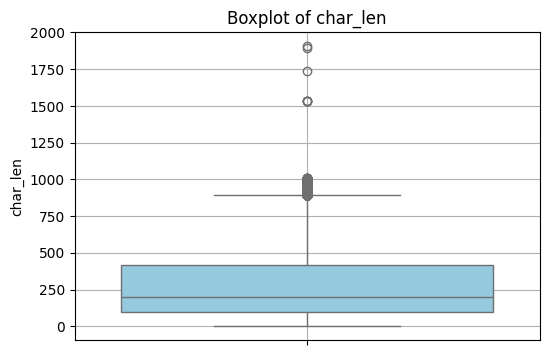

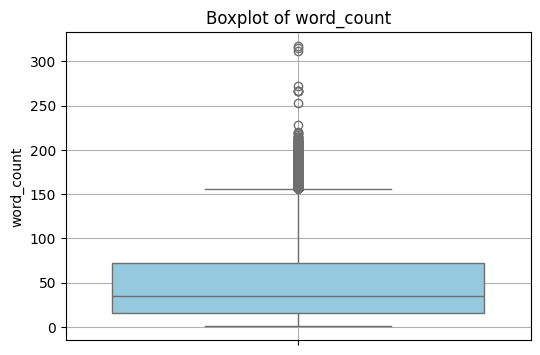

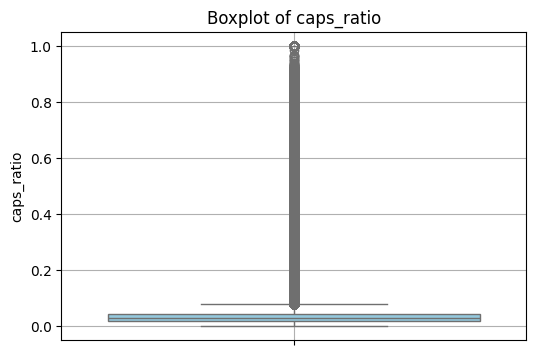

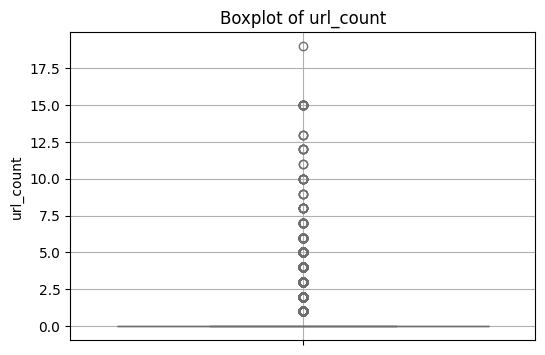

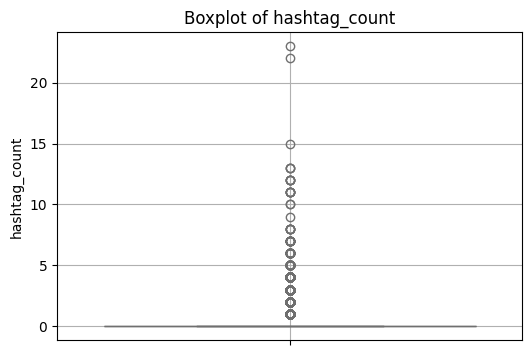

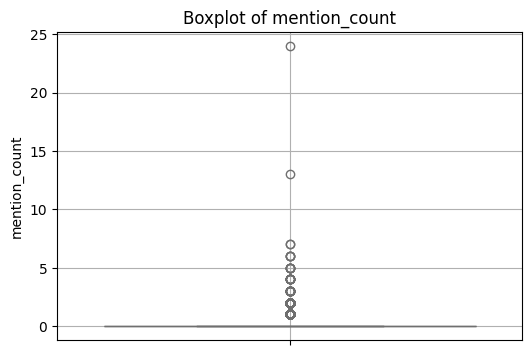

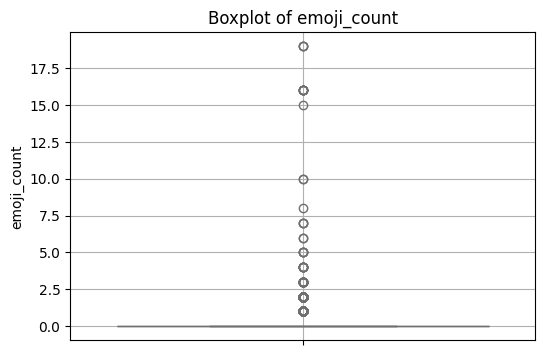

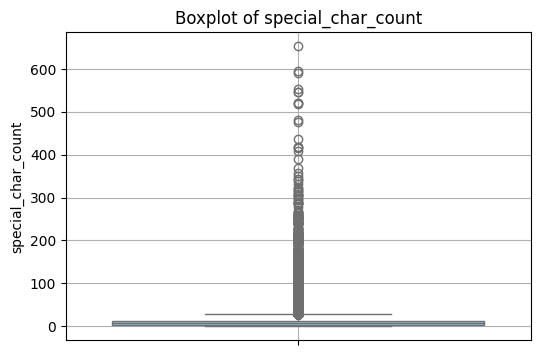

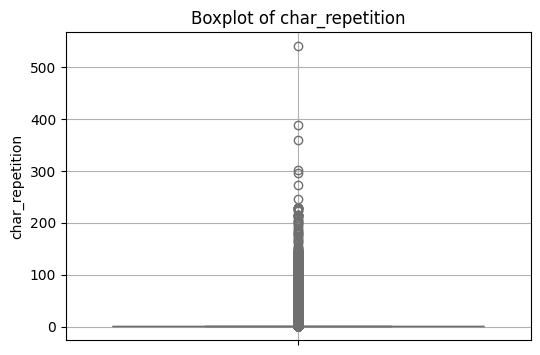

In [44]:
features = [
    "char_len", "word_count", "caps_ratio",
    "url_count", "hashtag_count", "mention_count",
    "emoji_count", "special_char_count", "char_repetition"
]

# plot each boxplot separately
for col in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=train_df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
    plt.grid(True)
    plt.show()

Using these boxplots, we will get to know/ approximate the values of the outliers, which will be used in spam detection. But for percision we will use `.descripe()`

In [45]:
train_df[features].describe()

,char_len,word_count,caps_ratio,url_count,hashtag_count,mention_count,emoji_count,special_char_count,char_repetition
count,1.804871e+06,1.804871e+06,1.804871e+06,1.804871e+06,1.804871e+06,1.804871e+06,1.804871e+06,1.804871e+06,1.804871e+06
mean,2.972348e+02,5.127698e+01,3.716819e-02,3.444346e-02,6.756162e-03,1.905399e-03,2.173563e-03,1.002776e+01,2.396612e+00
std,2.691966e+02,4.617811e+01,4.817963e-02,2.271167e-01,1.157209e-01,5.291927e-02,6.604389e-02,1.074886e+01,2.583230e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,9.400000e+01,1.600000e+01,1.785714e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,2.000000e+00
50%,2.020000e+02,3.500000e+01,2.745098e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,2.000000e+00
75%,4.140000e+02,7.200000e+01,4.225352e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,2.000000e+00
max,1.906000e+03,3.170000e+02,1.000000e+00,1.900000e+01,2.300000e+01,2.400000e+01,1.900000e+01,6.530000e+02,5.400000e+02


# Project SetUp:
- I assumed we will first find the binary value for `isSpam` using a hand_coded filter to train a ML spam learning model
- For the binary value `isToxic` it is determined using both a blacklist + a ML Toxic classifier
- The final asessment is risk = a * `isSpam` + b * `isToxic`
- The challenge is finding the right value for a, b


# spam detection

In [46]:
spam_patterns = [
    r"(http|www\.)",                       # URLs
    r"(free money|100% free|click here)",  # scammy promises
    r"(buy now|limited offer|discount)"    # sales language
]

compiled_patterns = [re.compile(p, re.IGNORECASE) for p in spam_patterns]

In [47]:
def isSpam(raw_comment):

  char_len = len(raw_comment)
  word_count = len(raw_comment.split())
  caps_ratio = sum(1 for c in raw_comment if c.isupper()) / len(raw_comment) if len(raw_comment) > 0 else 0
  url_count = len(url_pattern.findall(raw_comment))
  hashtag_count = len(hashtag_pattern.findall(raw_comment))
  mention_count = len(mention_pattern.findall(raw_comment))
  emoji_count = len(emoji_pattern.findall(raw_comment))
  special_char_count = len(special_char_pattern.findall(raw_comment))
  char_repetition = max_repetition(raw_comment)
  # based on .describe()
  if(char_len > 1.906000e+03 or word_count > 3.170000e+02 or caps_ratio > 1.000000e+00 or url_count > 1.900000e+01 or hashtag_count > 2.300000e+01 or mention_count > 2.400000e+01 or emoji_count > 1.900000e+01 or special_char_count > 6.530000e+02	or char_repetition > 5.400000e+02
):
        return 1

  elif any(p.search(raw_comment) for p in compiled_patterns):
        return 1

  else:
        return None # not spam


Now, how do we get the scores?
- We have a huge dataset, so if we create a new column for spam_label, maybe we will get Nans, but we will be able to build a model.
- We’ll take all positives and a random sample of unlabeled as temporary negatives.

In [48]:
# apply to dataset, ISPAM = isSpam
train_df["ISPAM"] = train_df["comment_text"].apply(isSpam)

In [49]:
train_df["ISPAM"].value_counts()

,count
ISPAM,
1.0,56037


We will use Logistic Regression since it can give us probabilities

In [50]:
pos_df = train_df[train_df["ISPAM"] == 1]

In [51]:
unlabeled_df = train_df[train_df["ISPAM"].isna()]

In [52]:
# sample negatives (2x positives for balance)
neg_df = unlabeled_df.sample(len(pos_df)*2, random_state=42)

In [53]:
train_pu = pd.concat([pos_df, neg_df]) # to add them in one column
train_pu["PU_LABEL"] = np.where(train_pu["ISPAM"]==1, 1, 0)

In [54]:
train_pu["PU_LABEL"].value_counts()

,count
PU_LABEL,
0,112074
1,56037


In [55]:
X_train, X_val, y_train, y_val = train_test_split(
    train_pu["comment_text"], train_pu["PU_LABEL"],
    test_size=0.2, random_state=42
)

In [56]:
pu_clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [57]:
pu_clf.fit(X_train, y_train)

print("Validation accuracy:", pu_clf.score(X_val, y_val))

Validation accuracy: 0.9907801207506767


In [58]:
train_df["SPAM_SCORE"] = pu_clf.predict_proba(train_df["comment_text"].fillna(""))[:,1]

`.predict_proba()` It returns an array with 2 columns:

column 0 → probability of class 0 (not spam)

column 1 → probability of class 1 (spam)

[:,1] → take only the spam probability column.

store this in a new column SPAM_SCORE and there are nans.

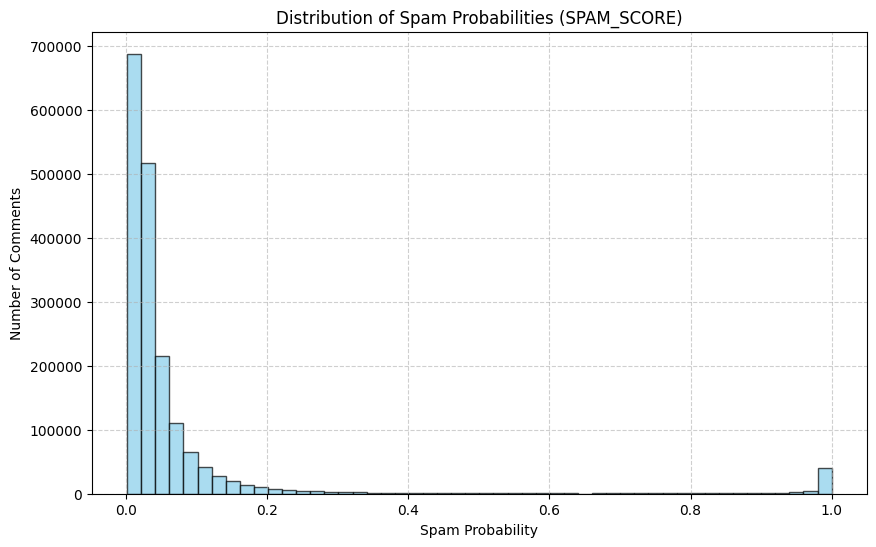

In [59]:
# we should visualize it before applying a threshold

plt.figure(figsize=(10,6))
plt.hist(train_df["SPAM_SCORE"], bins=50, color="skyblue", edgecolor="black", alpha=0.7)
plt.title("Distribution of Spam Probabilities (SPAM_SCORE)")
plt.xlabel("Spam Probability")
plt.ylabel("Number of Comments")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Most comments are near 0 → model thinks they’re not spam.

A smaller spike near 1.0 → very likely spam.

I think that 0.65, any value > 6, separates the two classes well

In [60]:
train_df[["comment_text", "ISPAM", "SPAM_SCORE"]].head(20)

,comment_text,ISPAM,SPAM_SCORE
0,"This is so cool. It's like, 'would you want yo...",NaN,0.016490
1,Thank you!! This would make my life a lot less...,NaN,0.009314
2,This is such an urgent design problem; kudos t...,NaN,0.026166
3,Is this something I'll be able to install on m...,NaN,0.037010
4,haha you guys are a bunch of losers.,NaN,0.006894
5,ur a sh*tty comment.,NaN,0.010924
6,hahahahahahahahhha suck it.,NaN,0.008086
7,FFFFUUUUUUUUUUUUUUU,NaN,0.009361
8,The ranchers seem motivated by mostly by greed...,NaN,0.013239
9,It was a great show. Not a combo I'd of expect...,NaN,0.007502


In [61]:
train_df[train_df['SPAM_SCORE']>0.77]['comment_text'].head(20) # i tried different values for the thresold, i think 0.77 is the most suitable

,comment_text
33,Troll free since 2016.
68,I think you left out one very important organi...
100,Loving this collection. Cant wait till Season ...
117,"Richard Ellmyer, check out Agent Bretzing's of..."
123,Took this as an opportunity to check back in o...
151,The foster care system has been broken for mor...
172,What is the foundation of the Harney County pr...
201,It's worth noting Lizzy Acker quotes a sensati...
233,Here's a link to the actual ballot measure tha...
240,"""Brewers love weed. I didn't know that before ..."


In [62]:
threshold = 0.77
train_df["ISPAM"] = (train_df["SPAM_SCORE"] >= threshold).astype(int)

In [63]:
train_df["ISPAM"].value_counts()

,count
ISPAM,
0,1750293
1,54578


In [64]:
# let's see the results
train_df[train_df['ISPAM']==0].head(20)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,word_count,caps_ratio,url_count,hashtag_count,mention_count,emoji_count,special_char_count,char_repetition,ISPAM,SPAM_SCORE
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,19,0.029703,0,0,0,0,9,2,0,0.016490
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,22,0.026316,0,0,0,0,7,2,0,0.009314
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,16,0.023256,0,0,0,0,3,2,0,0.026166
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,17,0.035714,0,0,0,0,3,2,0,0.037010
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,...,8,0.000000,0,0,0,0,1,1,0,0.006894
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,0.0,0.0,...,4,0.000000,0,0,0,0,2,2,0,0.010924
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,0.0,0.0,...,3,0.000000,0,0,0,0,1,3,0,0.008086
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,1,1.000000,0,0,0,0,0,15,0,0.009361
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,21,0.008333,0,0,0,0,2,2,0,0.013239
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,18,0.037500,0,0,0,0,3,2,0,0.007502


# Text Cleaning and normalization

In [65]:
def preprocess_text(text):
    text = str(text).lower()

    # Replace URLs, mentions, hashtags first
    text = url_pattern.sub(" <URL> ", text)
    text = mention_pattern.sub(" <USER> ", text)
    text = hashtag_pattern.sub(" <HASHTAG> ", text)

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Replace numbers with <NUM>
    text = re.sub(r"\d+", " <NUM> ", text)

    # Replace emojis with placeholder
    text = emoji_pattern.sub(" <EMOJI> ", text)

    # Normalize repeated characters (soooo → soo)
    #    the . means any char, and parentheses make it a group and repeat the captured character at least 2 more times
    #    then replace them with just 2 occurrences of that character
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # Normalize whitespace (your requested line)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = text.split()

    # Remove stopwords (keep negations)
    tokens = [w for w in tokens if w not in stop_words or w in ["not", "no", "never"]]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    # Rejoin
    return " ".join(tokens)

In [66]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [67]:
train_df["cleaned_comment"] = train_df["comment_text"].apply(preprocess_text)
train_df[["comment_text", "cleaned_comment"]].head()

,comment_text,cleaned_comment
0,"This is so cool. It's like, 'would you want yo...","cool. like, 'would want mother read this??' re..."
1,Thank you!! This would make my life a lot less...,thank you!! would make life lot less anxiety-i...
2,This is such an urgent design problem; kudos t...,urgent design problem; kudos taking on. impres...
3,Is this something I'll be able to install on m...,something able install site? releasing it?
4,haha you guys are a bunch of losers.,haha guy bunch losers.


# toxic text detection

In [68]:
blacklist = [
    "nigger", "nigga", "kike", "wetback", "spic", "raghead", "coon",
    "jigaboo", "jiggerboo", "slanteye", "chink", "honkey", "darkie",
    "child porn", "pthc", "nambla", "pedobear", "pedophile", "paedophile",
    "jailbait", "lolita",
    "rape", "rapist", "raping", "incest", "bestiality", "beastiality",
    "necrophilia", "snuff",
    "terrorist", "suicide bombing", "swastika", "neonazi", "white power",
    "fuck", "fucking", "motherfucker", "shit", "bullshit", "cunt",
    "dick", "cock", "pussy", "bitch", "asshole", "bastard", "fucktard",
    "blowjob", "anal", "cumshot", "facial", "creampie", "bukkake",
    "gangbang", "fisting", "handjob", "rimjob", "deepthroat"
]

In [69]:
toxic_cols = ["target","severe_toxicity", "obscene","identity_attack", "insult", "threat", "sexual_explicit"]

In [70]:
def isToxic(row, blacklist, toxic_cols, threshold=0.5):
    text = str(row["cleaned_comment"])
   # 1) Blacklist check
    for w in blacklist:
        if re.search(rf"\b{re.escape(w)}\b", text):
            return 1  # toxic

    # 2) Threshold check
    if any(row[col] >= threshold for col in toxic_cols):
        return 1  # toxic

    return 0


In [71]:
toxic_cols = ["target", "severe_toxicity", "obscene", "identity_attack", "insult", "threat", "sexual_explicit"]

train_df["isToxic"] = train_df.apply(
    lambda r: isToxic(r, blacklist, toxic_cols, threshold=0.5), axis=1
)

In [72]:
train_df["isToxic"].value_counts()

,count
isToxic,
0,1639832
1,165039


In [73]:
train_df[["cleaned_comment","isToxic"]].head(20)

,cleaned_comment,isToxic
0,"cool. like, 'would want mother read this??' re...",0
1,thank you!! would make life lot less anxiety-i...,0
2,urgent design problem; kudos taking on. impres...,0
3,something able install site? releasing it?,0
4,haha guy bunch losers.,1
5,ur sh*tty comment.,1
6,hahahahahahahahha suck it.,0
7,ffuu,0
8,rancher seem motivated mostly greed; no one ri...,0
9,great show. not combo expected good together was.,0


In [74]:
X = train_df["cleaned_comment"]
y = train_df["isToxic"]

In [75]:
# smaller sample for speed, rf
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=200_000, stratify=y, random_state=42)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

In [77]:
tfidf = TfidfVectorizer(
    max_features=100_000,  # cap vocab size
    ngram_range=(1,2),     # unigrams + bigrams
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [78]:
def evaluate_model(name, model, X_val_tfidf, y_val, proba=True):
    """
    Evaluate model with Accuracy, Precision, Recall, F1, ROC-AUC
    """
    if proba:  # models with predict_proba
        y_pred_proba = model.predict_proba(X_val_tfidf)[:,1]
    else:      # models without predict_proba (like LinearSVC)
        y_pred_proba = model.decision_function(X_val_tfidf)

    y_pred = model.predict(X_val_tfidf)

    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("ROC AUC:", roc_auc_score(y_val, y_pred_proba))

In [79]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
evaluate_model("Naive Bayes", nb, X_test_tfidf, y_test, proba=True)


=== Naive Bayes ===
Accuracy: 0.91055
ROC AUC: 0.7785254149408638


In [80]:
svm = LinearSVC(class_weight="balanced")
svm.fit(X_train_tfidf, y_train)
evaluate_model("Linear SVC", svm, X_test_tfidf, y_test, proba=False)


=== Linear SVC ===
Accuracy: 0.921375
ROC AUC: 0.9123508614549415


In [81]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_tfidf, y_train)
evaluate_model("Logistic Regression", log_reg, X_test_tfidf, y_test, proba=True)


=== Logistic Regression ===
Accuracy: 0.911225
ROC AUC: 0.9293598156782705


We need weights, but svm doesn't give probabilities. So, we will choose log_reg

In [82]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_tfidf, y_train)
evaluate_model("Random Forest", rf, X_test_tfidf, y_test, proba=True)


=== Random Forest ===
Accuracy: 0.86305
ROC AUC: 0.8189455743631489


We will not choose RandomForest

In [83]:
# from sklearn.ensemble import VotingClassifier

# ensemble = VotingClassifier(
#     estimators=[("svm", svm), ("logreg", log_reg)],
#     voting="soft",  # use probabilities
#     weights=[0.4, 0.6]  # we will give the bigger weight for the model with the highest AUC-ROC
# )

# Risk Calculation

In [84]:
def isToxic_text(text: str, blacklist) -> int:
    """Text-only toxic rule for unseen data (no toxic_cols there)."""
    text = str(text or "")
    for w in blacklist:
        if re.search(rf"\b{re.escape(w)}\b", text):
            return 1
    return 0

In [85]:
def risk_assessment(row, toxic_model, spam_model, toxic_vectorizer):
    # Clean the text using your preprocessing function
    raw = row.get("comment_text", "")
    cleaned = preprocess_text(raw)

    # model probs
    tox_features = toxic_vectorizer.transform([cleaned])
    tox_p = toxic_model.predict_proba(tox_features)[0, 1]
    spam_p = spam_model.predict_proba([raw])[0, 1]

    # rule overrides: if rule says 1 -> force 1, else use prob
    spam_flag = isSpam(raw)
    final_spam = 1.0 if spam_flag == 1 else float(spam_p)

    tox_flag = isToxic_text(cleaned, blacklist)
    final_tox = 1.0 if tox_flag == 1 else float(tox_p)

    # combine (tune as you like)
    risk = 0.85 * final_tox + 0.15 * final_spam
    return float(min(1.0, max(0.0, risk)))

In [86]:
eval_df = pd.DataFrame({"comment_text": X_test})
eval_df["risk_score"] = eval_df.apply(lambda r: risk_assessment(r, log_reg, pu_clf, tfidf), axis=1)

In [87]:
from sklearn.metrics import precision_recall_curve

In [88]:
# we choose threshold by best F1 on held-out labels
prec, rec, thresh = precision_recall_curve(y_test.values, eval_df["risk_score"].values)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = int(np.argmax(f1_scores))
best_thresh = float(thresh[max(0, min(best_idx, len(thresh)-1))])
print("\nRisk model best F1 threshold:", round(best_thresh, 4))


Risk model best F1 threshold: 0.5861


In [89]:
y_pred_final = (eval_df["risk_score"] >= best_thresh).astype(int)
print("  Final Accuracy:", round(accuracy_score(y_test, y_pred_final), 4))
print("  Final Precision:", round(precision_score(y_test, y_pred_final), 4))
print("  Final Recall:", round(recall_score(y_test, y_pred_final), 4))
print("  Final F1:", round(f1_score(y_test, y_pred_final), 4))
print("  Final ROC AUC:", round(roc_auc_score(y_test, eval_df["risk_score"]), 4))

  Final Accuracy: 0.9362
  Final Precision: 0.6554
  Final Recall: 0.6465
  Final F1: 0.6509
  Final ROC AUC: 0.9319


We will apply the threshold to make the final binary prediction

# Let's evaluate the final model

In [90]:
merged_df

,id,comment_text,prediction
0,7097320,[ Integrity means that you pay your debts.]\n\...,0.0
1,7097321,This is malfeasance by the Administrator and t...,0.0
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,0.0
3,7097323,"Paul: Thank you for your kind words. I do, in...",0.0
4,7097324,Sorry you missed high school. Eisenhower sent ...,0.0
...,...,...,...
97315,7194635,He should lose his job for promoting mis-infor...,0.0
97316,7194636,"""Thinning project is meant to lower fire dange...",0.0
97317,7194637,I hope you millennials are happy that you put ...,0.0
97318,7194638,I'm thinking Kellyanne Conway (a.k.a. The Trum...,0.0


In [91]:
merged_df["risk_score"] = merged_df.apply(
    lambda r: risk_assessment(r, log_reg, pu_clf, tfidf), axis=1
)

In [92]:
merged_df["risk_label"] = (merged_df["risk_score"] >= best_thresh).astype(int)

In [93]:
y_true = merged_df["prediction"]   # replace "target" with the actual ground-truth column
y_pred = merged_df["risk_label"]

In [94]:
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 0.9105322646937937
